In [1]:
# Basic Libraries
from typing import List, Tuple, Union
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import pandas as pd
import librosa
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, random_split, Dataset
import librosa.display
import matplotlib.pyplot as plt
import tarfile
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import wave
# Libraries for Classification and building Models
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC
# Project Specific Libraries
import os
import librosa
import librosa.display
import glob 
import skimage

In [3]:
print(torch.version.cuda)

11.6


In [2]:
import torch
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")
device=get_default_device()


# Data loading

In [4]:
df = pd.read_csv("../urbansound8k/metadata/UrbanSound8K.csv")

'''We will extract classes from this metadata.'''

df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [12]:
df.isna().sum()

slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64

Minimum samples per category =  374
Maximum samples per category =  1000


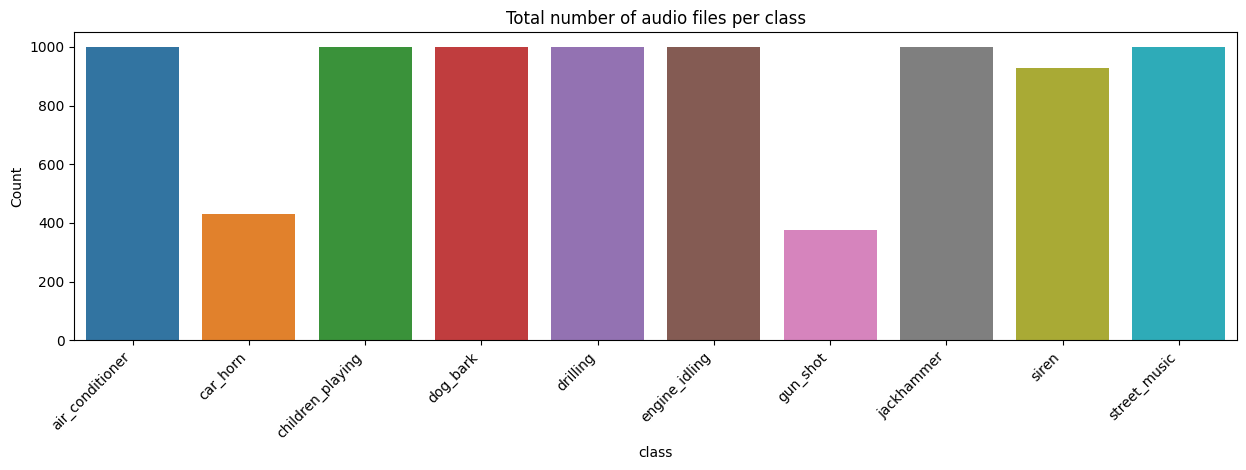

In [9]:
plt.figure(figsize=(15,4))
labels_grouped = df.groupby(by=['class'], ).count()
chart = sns.barplot(x=labels_grouped.index, y=labels_grouped["slice_file_name"])
chart.set_xticklabels(labels=chart.get_xticklabels(), rotation=45, horizontalalignment='right');
chart.set_title("Total number of audio files per class");
chart.set_ylabel('Count');
print('Minimum samples per category = ', min(df['class'].value_counts()))
print('Maximum samples per category = ', max(df['class'].value_counts()))

 
Maybe stratify dataset or use focal loss function or weighted loss function for *gun_shot* or *car_horn*

## Sound Distribution 

In [55]:
def get_nframes(df: pd.DataFrame):
    data = np.zeros((len(df), 2))
    df_filtered = pd.DataFrame(data, columns=["nframes", "class"])

    for i in range(len(df)):
        try:
            fold=df["fold"].iloc[i]
            filename=df["slice_file_name"].iloc[i]
            path="../urbansound8k/audio/fold{0}/{1}".format(fold, filename)
            nframe = wave.open(path).getnframes()
            df_filtered["nframes"][i] = nframe
            df_filtered["class"][i] = df["class"].iloc[i]
        except:
            print("Error for {}".format(path))
    return df_filtered

In [ ]:
df_filtered = get_nframes(df)
_, ax = plt.subplots(figsize=(16, 4))
sns.violinplot(ax=ax, x="class", y="nframes", data=df_filtered)
plt.xticks(rotation=45)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()

## Analyse a sound

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

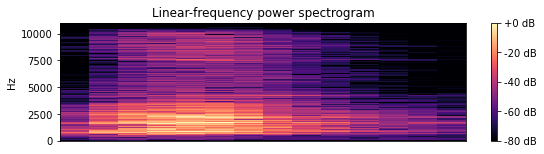

In [31]:
dat1, sampling_rate1 = librosa.load('../urbansound8k/audio/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load('../urbansound8k/audio/fold5/100263-2-0-117.wav')

plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

## Mel-frequency cepstral coefficients (MFCCs)
#### Generate mfccs from a wav files
``Note : We can tune parameters hop_length=1024, htk=True and n component n_mfcc=50 from *mfcc* function``

In [43]:
def get_mfcc(wav: str):
    dat, sr = librosa.load(wav)
    mfccs = librosa.feature.mfcc(y=dat, sr=sr, hop_length=1024, htk=True, n_mfcc=50)
    S = librosa.feature.melspectrogram(y=dat, sr=sr, n_mels=128,
                                   fmax=8000)
    return mfccs, S

In [45]:
mfcc_bark, S_bark = get_mfcc("../urbansound8k/audio/fold1/7383-3-0-0.wav")
mfcc_birds, S_birds = get_mfcc("../urbansound8k/audio/fold2/4201-3-1-0.wav")
mfcc_street_music, S_street_music = get_mfcc("../urbansound8k/audio/fold2/14387-9-0-15.wav")

## Visualize MFCC 

In [4]:
def show_mfcc(mfccs, S):
    fig, ax = plt.subplots(nrows=2, sharex=True)
    img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                                x_axis='time', y_axis='mel', fmax=10000,
                                ax=ax[0])
    fig.colorbar(img, ax=[ax[0]])
    ax[0].set(title='Mel spectrogram')
    ax[0].label_outer()
    img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
    fig.colorbar(img, ax=[ax[1]])
    ax[1].set(title='MFCC')

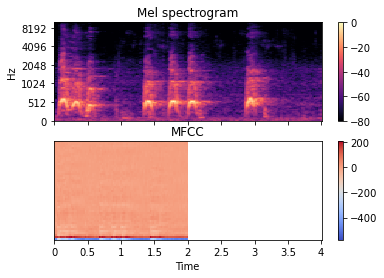

In [46]:
show_mfcc(mfcc_bark, S_bark)

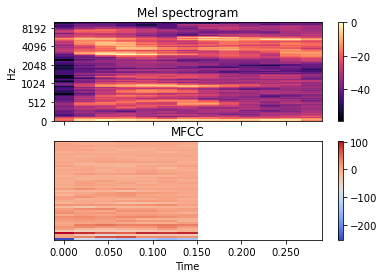

In [47]:
show_mfcc(mfcc_birds, S_birds)

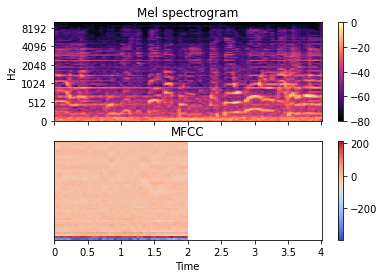

In [48]:
show_mfcc(mfcc_street_music, S_street_music)

## Features extraction and Modeling

### Save the dataset with labels 

In [ ]:
# Helper function to generate mfccs
def extract_mfcc(path):
    audio, samplerate=librosa.load(path)
    mfccs=librosa.feature.mfcc(y=audio, sr=samplerate, n_mfcc=50)
    return np.mean(mfccs.T, axis=0)

df=pd.read_csv("../urbansound8k/metadata/UrbanSound8K.csv")
features=[]
labels=[]
folds=[]
for i in range(len(df)):
    fold=df["fold"].iloc[i]
    filename=df["slice_file_name"].iloc[i]
    path="../urbansound8k/audio/fold{0}/{1}".format(fold, filename)
    #mfccs=extract_mfcc(path)
    print("{}/{} - Sample {}".format(i, len(df), filename))
    audio, samplerate=librosa.load(path)
    features.append(audio)
    folds.append(fold)
    labels.append(df["classID"].iloc[i])

features=torch.tensor(features)
labels=torch.tensor(labels)
folds=torch.tensor(folds)
# Saving the dataset to disk to prevent re-Loading
print("Saving dataset to disk ..")
torch.save(features, "../data/audio.pt")
torch.save(labels, "../data/labels.pt")
torch.save(folds, "../data/folds.pt")

### Pad your tensor (audio have different size)

In [79]:
def pad(features: List[np.ndarray]) -> np.array:
    biggest_dim = 0
    for i in range(0, len(features)):
        if features[i].shape[0] > biggest_dim:
            biggest_dim = features[i].shape[0]
    print("Biggest dim : {}".format(biggest_dim))
    pad_features = []
    for feature in features:
        tmp = np.zeros(biggest_dim)
        tmp[:feature.shape[0]] = feature
        pad_features.append(tmp)
    
    return np.array(pad_features, dtype=np.float32)

np_features = pad(features)
features_torch=torch.tensor(np_features)
torch.save(features_torch, '../data/audio.pt',_use_new_zipfile_serialization=False)

In [ ]:
np_features = np.array(features, dtype=np.float32)
np_features = np_features.reshape(1, len(features))

features=torch.tensor(np_features)
labels=torch.tensor(labels)
folds=torch.tensor(folds)
# Saving the dataset to disk to prevent re-Loading
print("Saving dataset to disk ..")
torch.save(features, "../data/audio.pt")
torch.save(labels, "../data/labels.pt")
torch.save(folds, "../data/folds.pt")

### Load the dataset with features, labels and folds

In [ ]:
def get_dataset(skip_fold):
    local_features=[]
    local_labels=[]
    for i in range(len(folds)):
        if folds[i]==skip_fold:
            continue
        local_features.append(features[i])
        local_labels.append(labels[i])
    local_features=torch.stack(local_features)
    local_labels=torch.stack(local_labels)
    return TensorDataset(local_features, local_labels)

In [ ]:
dataset=get_dataset(skip_fold=10)
len(dataset)

In [5]:
features=torch.load("../data/audio.pt")
labels=torch.load("../data/labels.pt")
folds=torch.load("../data/folds.pt")
labels = torch.tensor(labels)
dataset = TensorDataset(features, labels)

In [7]:
val_size=int(0.1*len(dataset))
train_size=len(dataset)-val_size

train_ds, val_ds=random_split(dataset, [train_size, val_size])

len(train_ds), len(val_ds)

(7859, 873)

In [8]:
batch_size=32
train_loader=DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader=DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

# Looking at a batch of data
for x,y in train_loader:
    print(f"feautres: {x}\nlabels: {y}")
    print(f"dtypes: (x)->{x.dtype}, (y)->{y.dtype}")
    break

feautres: tensor([[ 0.0038,  0.0053,  0.0029,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0230, -0.0253, -0.0235,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1290, -0.1892, -0.1360,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0042,  0.0048,  0.0051,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0127, -0.0316, -0.0438,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0088,  0.0132,  0.0116,  ...,  0.0000,  0.0000,  0.0000]])
labels: tensor([5, 4, 0, 5, 5, 4, 0, 7, 0, 7, 4, 3, 6, 9, 5, 8, 3, 3, 9, 5, 3, 0, 6, 2,
        5, 2, 0, 0, 0, 2, 8, 6])
dtypes: (x)->torch.float32, (y)->torch.int64


# Training

In [11]:
import torch
print (torch.cuda.is_available())

True


In [12]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")
device=get_default_device()

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Defining an instance that moves all the tensors (DataLoaders) into the default device
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

# Moving the data to the device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [50]:
def evaluate(model, val_loader):
    model.eval()
    outputs=[model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def train(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.AdamW, print_loss=True):
    torch.cuda.empty_cache()
    history=[]
    optimizer= opt_func(model.parameters(), lr=lr, 
        betas=(0.9, 0.999), eps=1e-08, weight_decay=0.)

    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                       max_lr=5e-3,
                                                       steps_per_epoch=len(train_loader),
                                                       epochs=epochs,
                                                       pct_start=0.1,
                                                       )
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        with torch.no_grad():
            result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lr_scheduler.get_lr()
        # model.epoch_end(epoch, result)
        history.append(result)
        if print_loss:
            print(f"Epoch [{epoch}]: Lr -> {result[lrs]} Train Loss -> {result['train_loss']} Validation loss -> {result['val_loss']}, Validation accuracy -> {result['val_acc']} Precision -> {result['average_precision']} Recall -> {result['average_recall']}")
    return history

## Mobilenetv1

In [30]:
%load_ext autoreload
%autoreload 2
from models import MobileNetV1, Cnn10

model_args = {
      'sample_rate': 22050,
      'window_size': 1024,
      'hop_size': 320,
      'mel_bins': 64,
      'fmin': 50,
      'fmax': 20000,
      'classes_num': 10
    }
#model = MobileNetV1(**model_args)
model = Cnn10(**model_args)
to_device(model, device)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


l:\Logiciels\Anaconda3\envs\audio3.8\lib\site-packages\torchlibrosa\stft.py:193: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = librosa.util.pad_center(fft_window, n_fft)
l:\Logiciels\Anaconda3\envs\audio3.8\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


MobileNetV1(
  (spectrogram_extractor): Spectrogram(
    (stft): STFT(
      (conv_real): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
      (conv_imag): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
    )
  )
  (logmel_extractor): LogmelFilterBank()
  (spec_augmenter): SpecAugmentation(
    (time_dropper): DropStripes()
    (freq_dropper): DropStripes()
  )
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): AvgPool2d(kernel_size=1, stride=1, padding=0)
      (2): BatchNo

In [86]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 1.5773910284042358,
  'val_acc': 0.8241567611694336,
  'average_precision': 0.8241568207740784,
  'average_recall': 0.8241568207740784}]

In [96]:
def plot_losses(history, save=False, Doprint=True, path=None):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, label='val loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs')
    plt.legend()
    if Doprint:
        plt.show()
    if save:
        print("Saving loss ..")
        plt.savefig(os.path.join(path, 'loss.png'))

def plot_accuracies(history, save=False, Doprint=True, path=None):
    accuracies = [x['val_acc'] for x in history]
    recall = [x['average_recall'] for x in history]
    precision = [x['average_precision'] for x in history]
    
    plt.figure()
    # Plotting  the curves simultaneously
    ep = np.arange(0, len(accuracies), 1, dtype=np.int32)
    figure, axis = plt.subplots(2, 2)


    axis[0, 0].plot(ep, accuracies, color='b', label='accuracy')
    axis[0, 0].set_title("Accuracy")

    axis[0, 1].plot(ep, recall, color='g', label='recall')
    axis[0, 1].set_title("Recall")

    axis[1, 0].plot(ep, precision, color='r', label='precision')
    axis[1, 0].set_title("Precision")
 
    if Doprint:
        plt.show()

    if save:
        print("Saving metrics ..")
        plt.savefig(os.path.join(path, 'eval.png'))

def plot_lr(history, save=False, Doprint=True, path=None):
    lrs = [x['lrs'] for x in history]
    plt.plot(lrs, color='b', label='learning rate')
    plt.xlabel("Epochs")
    plt.ylabel("Learning rate")
    plt.title("Learning rate evolution")
    plt.legend()
    if Doprint:
        plt.show()
    if save:
        print("Saving lr ..")
        plt.savefig(os.path.join(path, 'lr.png'))



In [32]:
epochs=100
lr=0.005

history+=train(epochs, lr, model, train_loader, val_loader)


Epoch [0]: Train Loss -> 2.1089184284210205 Validation loss -> 2.0027008056640625, Validation accuracy -> 0.30307537317276 Precision -> 0.3030754029750824 Recall -> 0.3030754029750824
Epoch [1]: Train Loss -> 1.9728708267211914 Validation loss -> 1.9303373098373413, Validation accuracy -> 0.321552574634552 Precision -> 0.3215526044368744 Recall -> 0.3215526044368744
Epoch [2]: Train Loss -> 1.9427872896194458 Validation loss -> 1.8924553394317627, Validation accuracy -> 0.3808283805847168 Precision -> 0.3808284103870392 Recall -> 0.3808284103870392
Epoch [3]: Train Loss -> 1.8968276977539062 Validation loss -> 1.8670295476913452, Validation accuracy -> 0.3932291865348816 Precision -> 0.3932291865348816 Recall -> 0.3932291865348816
Epoch [4]: Train Loss -> 1.8691109418869019 Validation loss -> 1.8303314447402954, Validation accuracy -> 0.4216269850730896 Precision -> 0.4216269850730896 Recall -> 0.4216269850730896
Epoch [5]: Train Loss -> 1.8560352325439453 Validation loss -> 1.80132222

## Save model

In [ ]:
import os
def save_history(history, lr, epochs, model, bs):
    model_name = model.__class__.__name__
    path = 'history/{}_lr_{}_ep_{}_bs_{}_valoss_{}_acc_{}_recall_{}_precision_{}'.format(model_name, lr, epochs, batch_size, 
    round(history[len(history) -1]["val_loss"], 2), round(history[len(history) -1]["val_acc"], 2), round(history[len(history) -1]["average_recall"], 2), round(history[len(history) -1]["average_precision"], 2))
    
    os.mkdir(path)
    torch.save(model, os.path.join(path, 'model.pt'))
    plot_losses(history, save=True, Doprint=False, path=path)
    plot_accuracies(history, save=True, Doprint=False, path=path)
    plot_lr(history, save=True, Doprint=False, path=path)

save_history(history, lr, epochs, model, batch_size)
    

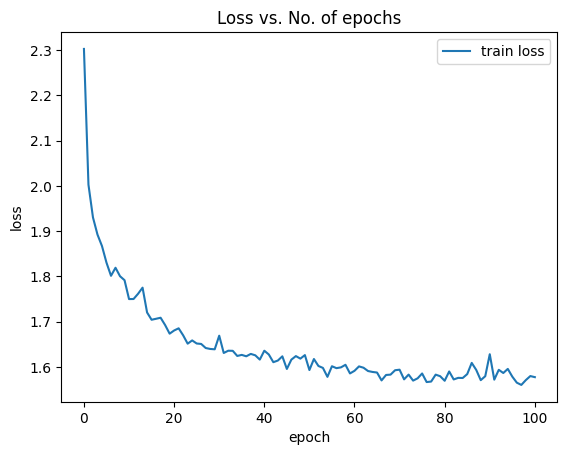

In [84]:
plot_losses(history)

<Figure size 640x480 with 0 Axes>

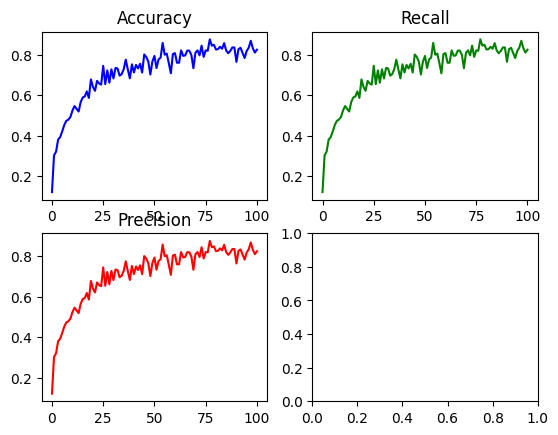

In [85]:
plot_accuracies(history)


In [47]:
plot_lr(history)

KeyError: 'lrs'

## Pytorch model with feature extractor

## Clues : Embedded AI, Sound localization ..